In [1]:
################################
####### Creating workers #######
################################
using Distributed
n_workers = 10
nprocs()==1 || rmprocs(workers()); addprocs(n_workers);

In [3]:
################################
#### Activating the project ####
################################
# push!(empty!(LOAD_PATH), "@")
@everywhere using Pkg
@everywhere Pkg.instantiate();
@everywhere Pkg.activate("../DistributedOptimization");
include("./src/DistributedOptimization.jl")

      From worker 6:	  Activating project at `~/Documents/Work/PhD 2A/julia_training/DiOp/DistributedOptimization`
      From worker 4:	  Activating project at `~/Documents/Work/PhD 2A/julia_training/DiOp/DistributedOptimization`
      From worker 11:	  Activating project at `~/Documents/Work/PhD 2A/julia_training/DiOp/DistributedOptimization`
      From worker 10:	  Activating project at `~/Documents/Work/PhD 2A/julia_training/DiOp/DistributedOptimization`
      From worker 8:	  Activating project at `~/Documents/Work/PhD 2A/julia_training/DiOp/DistributedOptimization`
      From worker 2:	  Activating project at `~/Documents/Work/PhD 2A/julia_training/DiOp/DistributedOptimization`
      From worker 7:	  Activating project at `~/Documents/Work/PhD 2A/julia_training/DiOp/DistributedOptimization`
      From worker 9:	  Activating project at `~/Documents/Work/PhD 2A/julia_training/DiOp/DistributedOptimization`
      From worker 3:	  Activating project at `~/Documents/Work/PhD 2A/julia_tr

  Activating project at `~/Documents/Work/PhD 2A/julia_training/DiOp/DistributedOptimization`


async_optimize (generic function with 1 method)

### Experiment setting

In [4]:
################################
###### Problem parameters ######
################################

using DistributedArrays
@everywhere using Random
@everywhere Random.seed!(42)

n = 1000
m = 20
λ = 0.01
zero_columns = 0

# active=0 returns 1
# active=1 Returns vector of ones with zeros at the ith block of size nworkers()
# active=2 Returns vector of zeros with ones at the ith block of size nworkers()
@everywhere function zeros_at(i,active=0)
    active==0 && return 1
    to_zero = [(i-1)*(m÷nworkers()) + k for k in 1:m÷nworkers()]
    active==1 && return [all(j .!= to_zero) for j in 1:m]
    active==2 && return [any(j .== to_zero) for j in 1:m]
end
    
A = [@spawnat worker rand(n÷nworkers(),m).*zeros_at(i,zero_columns)' for (i, worker) in enumerate(workers())]
A = reshape(A, :, 1)
A = DArray(A);

x_opt = rand(m,1) .+ 10

b = [@spawnat worker A.localpart*x_opt + 0.01*rand(Poisson(1),(n÷nworkers(),1)) for worker in workers()]
b = reshape(b, :, 1)
b = DArray(b);

objective = Objective(A,b,λ); # initializes worker_objective

In [4]:
################################
###### Learning parameters #####
################################

epochs = 0
time = 20
slow_workers = Dict(zip(workers()[1:2], [5,10]));
# slow_workers = Dict();
γ_paper = 1/objective.L
γ_piag  = 1/objective.L

0.00010037430188527714

### Experiment

In [12]:
##############################################################
################## Enforcing JIT compilation #################
##############################################################
async_optimize(rand(m,1), PaperSolver(objective, 1/objective.L), epochs=2);
async_optimize(rand(m,1), PiagSolver(objective, 1/objective.L), epochs=2);
sync_optimize(rand(m,1), PaperSolver(objective, 1/objective.L), epochs=2);

##############################################################
####################### Finding x_star #######################
##############################################################
paper_solver = PaperSolver(objective, 1/objective.L)
history_sync_paper = sync_optimize(rand(m,1), paper_solver; epochs=1000, verbose=100);
x_star = history_sync_paper.logs["x"][end];
norm(x_star-x_opt)

epoch=1, elapsed=0.0
epoch=100, elapsed=0.476714584
epoch=200, elapsed=0.947789959
epoch=300, elapsed=1.398757375
epoch=400, elapsed=1.84509275
epoch=500, elapsed=2.255239917
epoch=600, elapsed=2.650030917
epoch=700, elapsed=3.112034459
epoch=800, elapsed=3.6034115
epoch=900, elapsed=4.004969584
epoch=1000, elapsed=4.404111584


7.647264230990096

In [13]:
###############################################################
######################### Experiment ##########################
###############################################################

histories = Dict{String, Vector{History}}("piag"=>[], "paper"=>[], "sync"=>[])
# histories = Dict{String, Vector{History}}("paper"=>[],"sync"=>[])

for k in 1:5
    print("◀︎"); x_init = rand(m,1)
    
    ############################# SYNC ############################
    paper_solver = PaperSolver(objective, γ_paper);
    history = sync_optimize(x_init, paper_solver; slow_workers=slow_workers, epochs=epochs, time=time, verbose=0);
    append!(histories["sync"],[history])
    print("■")
    
    ########################### PAPER ###########################
    paper_solver = PaperSolver(objective, γ_paper); # initializes worker_solver
    history = async_optimize(x_init, paper_solver; slow_workers=slow_workers, epochs=epochs, time=time, verbose=0);
    append!(histories["paper"],[history])
    print("■")
    
    ############################ PIAG #############################
    piag_solver = PiagSolver(objective, γ_piag); # initializes worker_solver
    history = async_optimize(x_init, piag_solver; slow_workers=slow_workers, epochs=epochs, time=time, verbose=0);
    append!(histories["piag"],[history])
    print("■")
    
    print("▶︎")
end
println("◇")

◀︎■■■▶︎◀︎■■■▶︎◀︎■■■▶︎◀︎■■■▶︎◀︎■■■▶︎◇


### Saving & Loading experiment data

In [14]:
###############################################################
########################### Saving ############################
###############################################################

using JLD2, FileIO

file_name = "sync_async"

isdir("./data") || mkdir("./data");
parameters = Dict("n"=>n,"m"=>m,"λ"=>λ,"zero_columns"=>zero_columns, "epochs"=>epochs, "x_opt"=>x_opt
                  "time"=>time, "slow_workers"=>slow_workers, "γ_paper"=>γ_paper, "γ_piag" =>γ_piag)
save("./data/$file_name.jld2", "parameters", parameters, "histories", histories)

-- *Load from here* --

In [15]:
###############################################################
########################## Loading ############################
###############################################################

include("./src/DistributedOptimization.jl")
using JLD2, FileIO

file_name = "sync_async"
loaded_data = load("./data/$file_name.jld2")
histories   = loaded_data["histories"]
parameters  = loaded_data["parameters"];

In [ ]:
# x_star = mean([history.logs["x"][end] for history in histories["sync"]])

### Plots

In [17]:
###############################################################
########################### Plots #############################
###############################################################

using Plots
using PlotlyJS
using PGFPlotsX
using LaTeXStrings

function learning_curves(;xlabel, ylabel, yscale, histories, x_star, file_name="", save_as="")

    save_as in ["tex", "pdf", "tikz"] ? pgfplotsx() : gr()
    
    plt = Plots.plot(yscale=yscale, legend=:topright, grid=true, linewidth=4)
    
    h(x)  = sum(x.*log.(x))
    ∇h(x) = log.(x)
    
    ylabel=="norm"        && (D = (x,y) -> norm(x-y,2); ylabel!(L"||x^*-x^k||_2"))
    ylabel=="bregman"     && (D = (x,y) -> h(x) - h(y) - ∇h(y)⋅(x-y); ylabel!(L"D_h(x^*,x^k)"))
    ylabel=="abs_bregman" && (D = (x,y) -> abs(h(x) - h(y) - ∇h(y)⋅(x-y)); ylabel!(L"|D_h(x^*,x^k)|"))
    xlabel=="time"        && xlabel!("Time (s)")
    xlabel=="iterations"  && xlabel!("Iterations")
    xlabel=="epochs"      && xlabel!("Epochs")
    
    # end_iteration = min([min([history.iteration for history in algo_histories]...) 
    #                      for (algo_name, algo_histories) in histories]...)
    # end_time      = min([min([history.logs["elapsed"][end] for history in algo_histories]...) 
    #                      for (algo_name, algo_histories) in histories]...)
    # end_epoch     = min([min([history.epoch for history in algo_histories]...) 
    #                      for (algo_name, algo_histories) in histories]...)
    
    for ((algorithm, algo_histories), linestyle, color) in zip(histories, [:solid,:dot,:dash,:dash], [:palegreen2,:deepskyblue1,:salmon1,:orange])
        
        algorithm=="sync"  && (label="Synchronous Bregman Descent")
        algorithm=="paper" && (label="Asynchronous Bregman Descent")
        algorithm=="piag"  && (label="Piag Asynchronous Bregman Descent")
        
        tmp_xs = []
        tmp_ts = []
    
        end_iteration = min([history.iteration for history in algo_histories]...)
        end_epoch     = min([history.epoch for history in algo_histories]...)
        end_time      = min([history.logs["elapsed"][end] for history in algo_histories]...)

        for history in algo_histories
            xlabel=="iterations" && append!(tmp_xs, [[D(x_star,x) for x in history.logs["x"][1:end_iteration]]])
            xlabel=="time"       && append!(tmp_xs, [[D(x_star,x) for x in history.logs["x"][1:end_iteration]]])
            xlabel=="epochs"     && append!(tmp_xs, [[D(x_star,x) for x in history.logs["x"]][history.logs["epochs"][1:end_epoch]]])   
            xlabel=="time"       && append!(tmp_ts, [history.logs["elapsed"][1:end_iteration]])
        end

        if xlabel=="iterations" 
            xμs = mean(tmp_xs)
            xσs = std(tmp_xs)
            algorithm=="sync" && (xμs = xμs[repeat(1:end_iteration,inner=10)])
            algorithm=="sync" && (xσs = xσs[repeat(1:end_iteration,inner=10)])
            plot!(xμs, ribbon=xσs, fillalpha=.3, label=label, linestyle=linestyle, color=color)
        elseif xlabel=="epochs"
            xμs = mean(tmp_xs)
            xσs = std(tmp_xs)
            plot!(xμs, ribbon=xσs, fillalpha=.3, label=label, linestyle=linestyle, color=color)
        elseif xlabel=="time"
            tμs = mean(tmp_ts)
            xμs = mean(tmp_xs)[tμs .< end_time]
            xσs = std(tmp_xs)[tμs .< end_time]
            tμs = tμs[tμs .< end_time]
            # plot!(tμs, xμs, ribbon=xσs, fillalpha=.3, label=algorithm, linestyle=linestyle, color=color)
            # plot!(tμs, xμs, label=algorithm, linestyle=linestyle, color=color)
            plot!(tμs, xμs, label=label, linestyle=linestyle, color=color)
        end

    end
    
    isdir("./plots") || mkdir("./plots");
    save_as!="" && Plots.savefig(plt, "./plots/$file_name.$save_as")
    
    gr(); plt
end

########################### Annotation ##########################
# annotation = "n,m=($n,$m) slow_workers=$(values(slow_workers)) λ=$λ zero_columns=$zero_columns, γ_piag/paper=($(γ_piag*objective.L), $(γ_paper*objective.L))"
# txt = Plots.plot(grid=false, axis=false, ticks=false, size=(plt.attr[:size][1],100))
# annotate!(txt, [0], [0.5], text(annotation, 8, :gray, :left))
# Plots.plot(plt,txt, layout = grid(2,1,heights=(7.5/8,0.5/8)))
# display(plt)

learning_curves (generic function with 1 method)

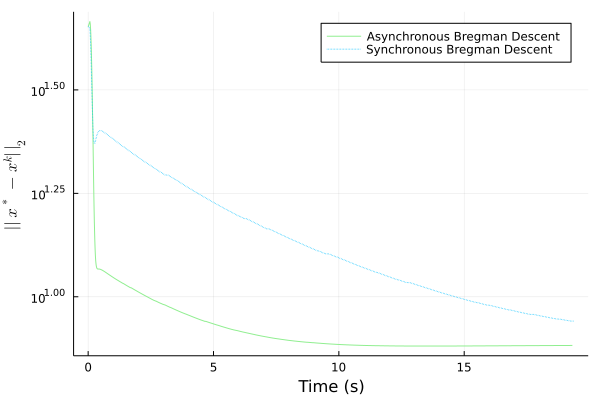

In [18]:
plt = learning_curves(xlabel    = "time", 
                      ylabel    = "norm", 
                      yscale    = :log, 
                      histories = Dict("sync"=>histories["sync"],"paper"=>histories["paper"]), 
                      x_star    = x_star,
                      file_name = file_name,
                      save_as   = "png")